<a href="https://colab.research.google.com/github/LeonMilosevic/covid_19_analysis/blob/main/covid_19_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid-19 EDA**

We will gain more insight on how countries with higher health index dealt with the Covid-19 pandemic. We will then explore what approach did South Korea take, as one of the countries that dealt best with the outbrake, after that we will try to create a model that will successfully predict if a person should be isolated or not. 

## Introduction



1. We will explore and compare how countries with higher health index rate dealt with the pandemic. 
2. We will explore how people of South Korea dealt with the outbrake and what decisions did the government made.
3. We will create a model to distinguish between released and isolated patients in South Korea. 

### Datasets used:


*   https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
*   https://www.kaggle.com/kimjihoo/coronavirusdataset/
*   https://www.kaggle.com/dumbgeek/countries-dataset-2020
*   https://www.kaggle.com/eng0mohamed0nabil/population-by-country-2020

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## High health index countries EDA

In [2]:
# all countries cases
countries_data = pd.read_csv('./covid_19_data.csv')

# healthcare of countries
countries_healthcare = pd.read_csv('./healthcare.csv')

# population of countries
countries_population = pd.read_csv('population_by_country_2020.csv')

South Korea has one of the best health care index in the world, we will compare it with countries that have similar healthcare, +-5

In [3]:
south_korea_healthcare = countries_healthcare[countries_healthcare['Country'] == 'South Korea']['Health Care Index'][1]

countries_strong_healthcare = countries_healthcare.loc[(countries_healthcare['Health Care Index'] >= south_korea_healthcare - 5) & 
                                                       (countries_healthcare['Health Care Index'] <= south_korea_healthcare + 5)]

Getting total number of cases for each country with similar healthcare points as South Korea

In [4]:
countries_cases_healthcare = pd.DataFrame(columns=countries_data.columns)

for i in range(len(countries_strong_healthcare.Country)):
  country = countries_strong_healthcare.Country[i]
  country_cases = countries_data[countries_data['Country/Region'] == country]

  countries_cases_healthcare.loc[i] = countries_data.iloc[country_cases['Confirmed'].idxmax()]

countries_cases_healthcare.reset_index(drop=True)

# australia was last updated in this dataset in october, so we will manually updated it
countries_cases_healthcare.loc[8, 'Confirmed'] = 27965.0
countries_cases_healthcare.loc[8, 'Deaths'] = 908.0
countries_cases_healthcare.loc[8, 'Recovered'] = 25639.0

Lets add population to each country so we can calculate proportion of the population that got infected

In [5]:
countries_cases_healthcare = pd.merge(
    countries_cases_healthcare, 
    countries_population, 
    how="left", 
    left_on="Country/Region",
    right_on="Country (or dependency)",
    )

countries_cases_healthcare.rename(
    columns={"Country/Region": "Country", 
             "Population (2020)": "Population"}, 
             inplace=True)

In [6]:
countries_cases_healthcare = countries_cases_healthcare[['Country', 'Confirmed', 'Deaths', 'Recovered', 'Population']]

In [7]:
countries_cases_healthcare['Active'] = countries_cases_healthcare['Confirmed'] - countries_cases_healthcare['Deaths'] - countries_cases_healthcare['Recovered']

countries_cases_healthcare['confirmed_p'] = countries_cases_healthcare['Confirmed'] / countries_cases_healthcare['Population']
countries_cases_healthcare['recovered_p'] = countries_cases_healthcare['Recovered'] / countries_cases_healthcare['Confirmed']
countries_cases_healthcare['death_p'] = countries_cases_healthcare['Deaths'] / countries_cases_healthcare['Confirmed']  
countries_cases_healthcare['active_p'] = countries_cases_healthcare['Active'] / countries_cases_healthcare['Confirmed']

In [11]:
# dropping france and spain since they dont have complete data
countries_cases_healthcare_plot = countries_cases_healthcare.drop([4, 5], axis=0)

In [12]:
# melting data for plotting
countries_cases_healthcare_plot_melted = pd.melt(countries_cases_healthcare_plot, id_vars='Country', value_vars=['Confirmed', 'Deaths', 'Recovered', 'Active'], value_name='cases')

# for proportions
countries_cases_healthcare_plot_proportions = pd.melt(countries_cases_healthcare_plot, id_vars='Country', value_vars=['confirmed_p', 'recovered_p', 'death_p', 'active_p'], value_name='cases')

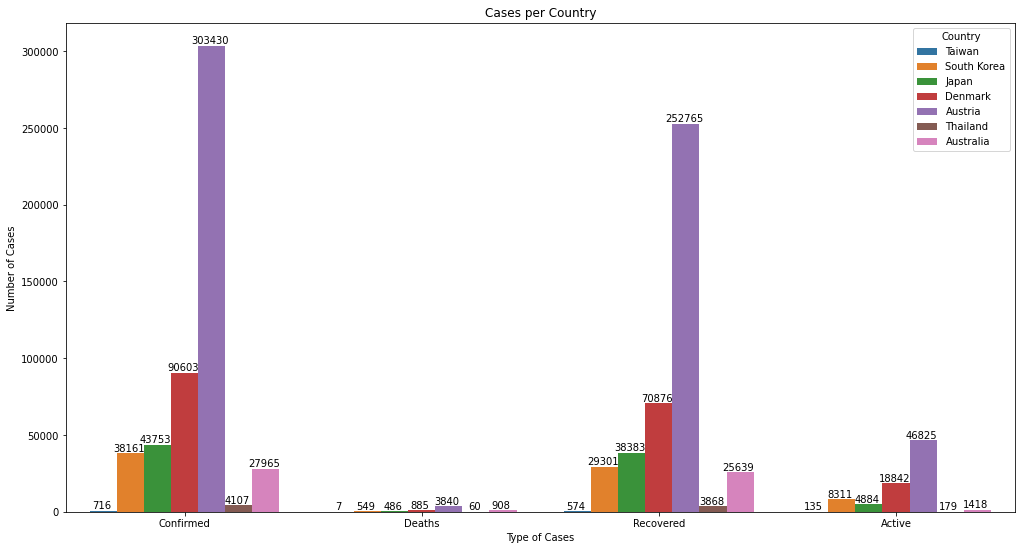

In [13]:
plt.figure(figsize=(17,9))
graph = sns.barplot(data=countries_cases_healthcare_plot_melted,y='cases', x='variable', hue='Country')
plt.xlabel('Type of Cases')
plt.ylabel('Number of Cases')
plt.title('Cases per Country')

for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x()+0.05, p.get_height()),
                 ha='center', 
                 va='bottom',
                 color= 'black')

Text(0.5, 1.0, 'Proportions of cases per Country')

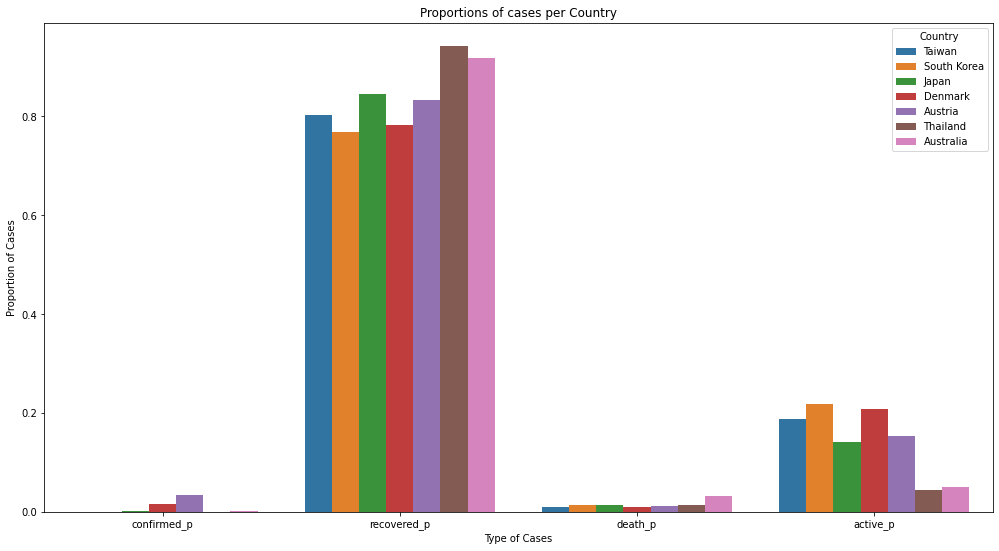

In [ ]:
# plotting proportions
plt.figure(figsize=(17,9))
graph = sns.barplot(data=countries_cases_healthcare_plot_proportions,y='cases', x='variable', hue='Country')
plt.xlabel('Type of Cases')
plt.ylabel('Proportion of Cases')
plt.title('Proportions of cases per Country')


#### Comparison Conclusion

We can see that Asian Countries with similiar Health care index, outperformed European Countries.

We can assume that Asian Countries were far better at detecting the virus and containing it since very low proportion of the population was infected.

While the treathment methods of both Top European and Asian countries gave similiar results, we can see that from the proportion of people who recovered and as well the death rate proportion is very similiar.



## South Korea EDA

In [2]:
# info of patients for cases registered
patient_info_data = pd.read_csv('./south_korea_data/PatientInfo.csv')

# goverment issued warnings
policy_data = pd.read_csv('./south_korea_data/Policy.csv')

# count data about regions, schools, kindergadens etc...
region_data = pd.read_csv('./south_korea_data/Region.csv')

# search trends by days for viruses
search_trend = pd.read_csv('./south_korea_data/SearchTrend.csv')

# age of the patients by day, confirmed and deceased
time_age_data = pd.read_csv('./south_korea_data/TimeAge.csv')

# province of patients by day, confirmed and deceased
time_province = pd.read_csv('./south_korea_data/TimeProvince.csv')

#### Lets discover the most affected age group

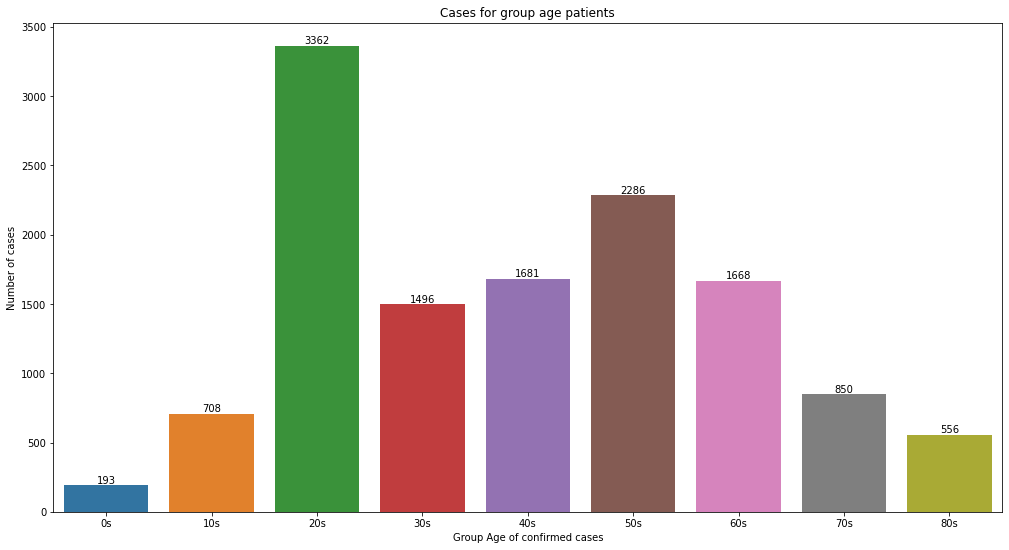

In [ ]:
plt.figure(figsize=(17,9))
graph = sns.barplot(y=time_age_data.confirmed[-9:], x=time_age_data.age.unique())

plt.xlabel('Group Age of confirmed cases')
plt.ylabel('Number of cases')
plt.title('Cases for group age patients')

for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x()+0.4, p.get_height()),
                 ha='center', 
                 va='bottom',
                 color= 'black')

###### Assumptions of why 20's is the most affected grouop
- Most socialy interactive group (parties, university, social events, gatherings)
- Media/Social networks, false information (Covid affects only elderly)

#### South Korea population reaction and government restrictions EDA

In [15]:
time_province['date'] = pd.to_datetime(time_province['date'])

time_province['active'] = time_province['confirmed'] - time_province['deceased'] - time_province['released']

time_province_total = time_province.groupby('date').sum()
time_province_total.drop(['time'], inplace=True, axis=1)

Text(0.5, 1.0, 'Total number of cases per month')

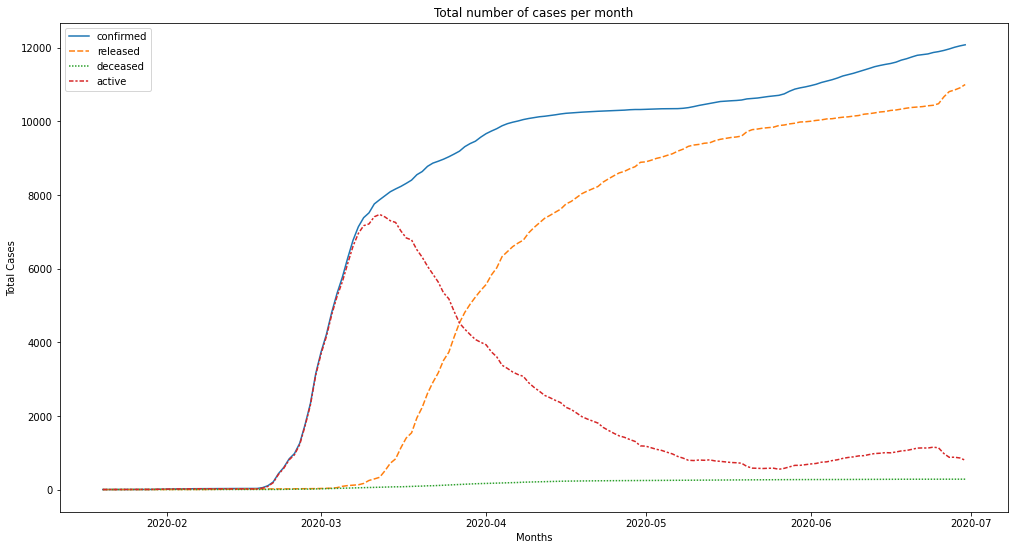

In [ ]:
plt.figure(figsize=(17,9))
sns.lineplot(data=time_province_total)

plt.xlabel('Months')
plt.ylabel('Total Cases')
plt.title('Total number of cases per month')

We can see on the plot that the active cases drop dramaticaly in March
- We will explore awareness of the people by search trends
- We will explore goverment raised restrictions

###### People Awareness

In [ ]:
search_trend['date'] = pd.to_datetime(search_trend['date'])

# based on wikipedia, covid has started in december 2019 so we will get search trends from november 2019
search_trend_nov = search_trend.loc[search_trend['date'] > '2019-11-01']

search_trend_nov.set_index('date', inplace=True)

In [ ]:
total_cases_search_trend = pd.merge(time_province_total, search_trend_nov[['coronavirus']], left_index=True, right_index=True)

# rescaling cases
total_cases_search_trend['confirmed'] = (total_cases_search_trend['confirmed'] / total_cases_search_trend['confirmed'].iloc[-1]) * 100
total_cases_search_trend['released'] = (total_cases_search_trend['released'] / total_cases_search_trend['released'].iloc[-1]) * 100
total_cases_search_trend['deceased'] = (total_cases_search_trend['deceased'] / total_cases_search_trend['deceased'].iloc[-1]) *100
total_cases_search_trend['active'] = (total_cases_search_trend['active'] / total_cases_search_trend['active'].max()) * 100

Text(0.5, 1.0, 'Cases and searching trends ')

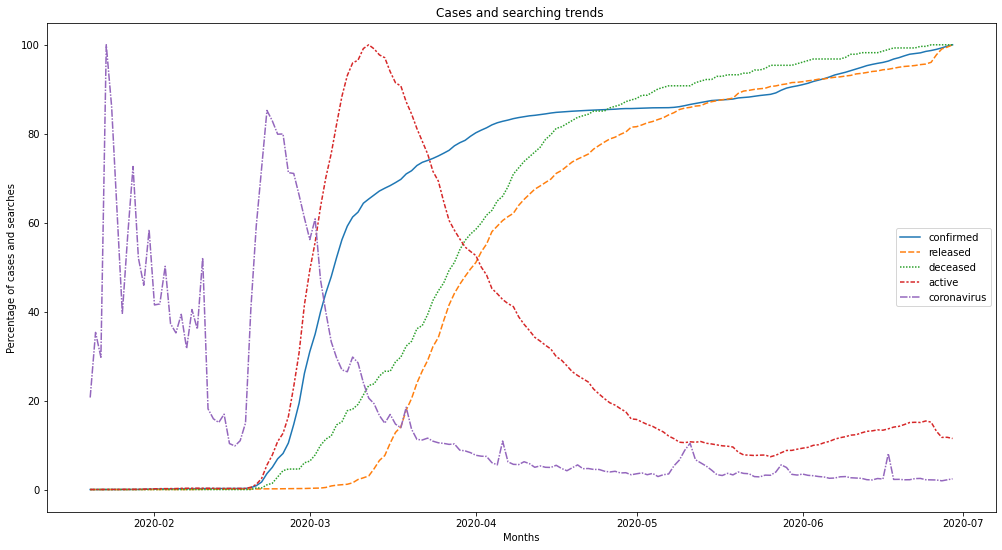

In [ ]:
plt.figure(figsize=(17,9))
sns.lineplot(data=total_cases_search_trend)

plt.xlabel('Months')
plt.ylabel('Percentage of cases and searches')
plt.title('Cases and searching trends ')

We can assume that there is positive correlation between awareness and number of active cases, the more people became aware of the covid, the active cases started dropping

###### Goverment Restrictions

In [16]:
policy_data.drop(['policy_id', 'country'], axis=1, inplace=True)
policy_data['start_date'] = pd.to_datetime(policy_data['start_date'])

In [ ]:
policy_data_by_start_date_count = policy_data.set_index('start_date')

policy_data_by_start_date_count['count'] = 1
policy_data_by_start_date_count = policy_data_by_start_date_count.resample('M').agg('sum')
policy_data_by_start_date_count = policy_data_by_start_date_count.reset_index()

policy_data_by_start_date_count['month'] = pd.DatetimeIndex(policy_data_by_start_date_count['start_date']).month

In [ ]:
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun'}

policy_data_by_start_date_count['month'] = policy_data_by_start_date_count['month'].apply(lambda x: month_names[x])

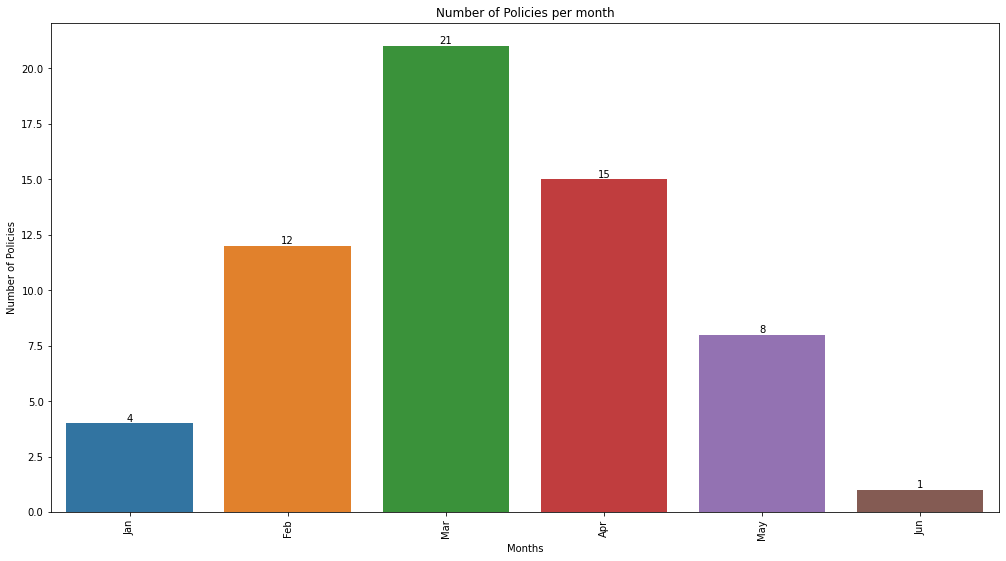

In [ ]:
plt.figure(figsize=(17,9))
graph = sns.barplot(data=policy_data_by_start_date_count, x='month', y='count')

plt.xlabel('Months')
plt.ylabel('Number of Policies')
plt.title('Number of Policies per month')
plt.xticks(rotation = 'vertical')

for p in graph.patches:
  graph.annotate('{:.0f}'.format(p.get_height()), 
                 (p.get_x()+0.4, p.get_height()),
                 ha='center', 
                 va='bottom',
                 color= 'black')

More than 20 policies have been introduced in March, thats when we saw our active cases dropping

Exploring type of Alerts that were introduced on a timeline

Text(0.5, 1.0, 'Total number of cases per month')

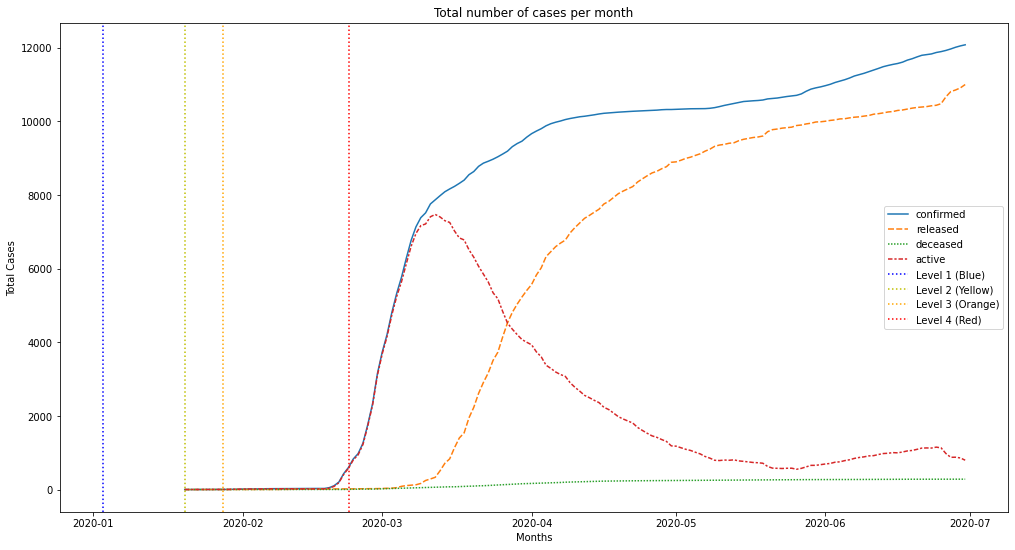

In [ ]:
policy_data_alerts = policy_data[policy_data['type'] == 'Alert']

plt.figure(figsize=(17,9))
ax = sns.lineplot(data=time_province_total)

xposition = policy_data_alerts['start_date']
colors = ['b', 'y', 'orange', 'r']
for i in range(len(policy_data_alerts['start_date'])):
  ax.axvline(x=policy_data_alerts['start_date'][i], color=colors[i], linestyle=':', label=policy_data_alerts['detail'][i])

plt.legend()
plt.xlabel('Months')
plt.ylabel('Total Cases')
plt.title('Total number of cases per month')

We can see how South Korea was reacting to the virus.

- Level 1 alert was introduced beginnig of January.
- After Level 4 was introduced, it took some days for symptoms to show. But we can see a decrease in cases, after the wave has passed.

## South Korea patients state prediction

In [3]:
patient_info_data = patient_info_data.drop_duplicates()

patient_info_data.drop(['patient_id', 
                        'country', 
                        'city','country', 
                        'infected_by', 
                        'contact_number', 
                        'symptom_onset_date', 
                        'released_date', 
                        'deceased_date',
                        'confirmed_date'], axis=1, inplace=True)

In [4]:
# drop patients with missing infeciton_cases
patient_info_data = patient_info_data.dropna(how='any', subset=['infection_case'])

In [5]:
# fill in missing values by proportion

#sex
sex_category = patient_info_data['sex'].value_counts(normalize=True, dropna=True).keys().tolist()
sex_proportion = patient_info_data['sex'].value_counts(normalize=True, dropna=True).values.tolist()

patient_info_data['sex'] = patient_info_data['sex'].fillna(pd.Series(np.random.choice(sex_category, p=sex_proportion, size=len(patient_info_data))))

#age
age_category = patient_info_data['age'].value_counts(normalize=True, dropna=True).keys().tolist()
age_proportion = patient_info_data['age'].value_counts(normalize=True, dropna=True).values.tolist()

patient_info_data['age'] = patient_info_data['age'].fillna(pd.Series(np.random.choice(age_category, p=age_proportion, size=len(patient_info_data))))

# removing the missing leftovers
patient_info_data = patient_info_data.dropna()

In [6]:
region_data_total = region_data[region_data['province'] == region_data['city']].copy()
region_data_total.drop(region_data_total.tail(1).index,inplace=True)

In [7]:
region_data_total.drop(['city', 'code'], inplace=True, axis=1)
patient_region_data = pd.merge(patient_info_data, region_data_total, how='inner', on='province')

Lets use TSNE to plot the data to get some intuition if we can make a successfull classification

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4232 samples in 0.045s...
[t-SNE] Computed neighbors for 4232 samples in 2.662s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4232
[t-SNE] Computed conditional probabilities for sample 2000 / 4232
[t-SNE] Computed conditional probabilities for sample 3000 / 4232
[t-SNE] Computed conditional probabilities for sample 4000 / 4232
[t-SNE] Computed conditional probabilities for sample 4232 / 4232
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.191597
[t-SNE] KL divergence after 300 iterations: 1.476552


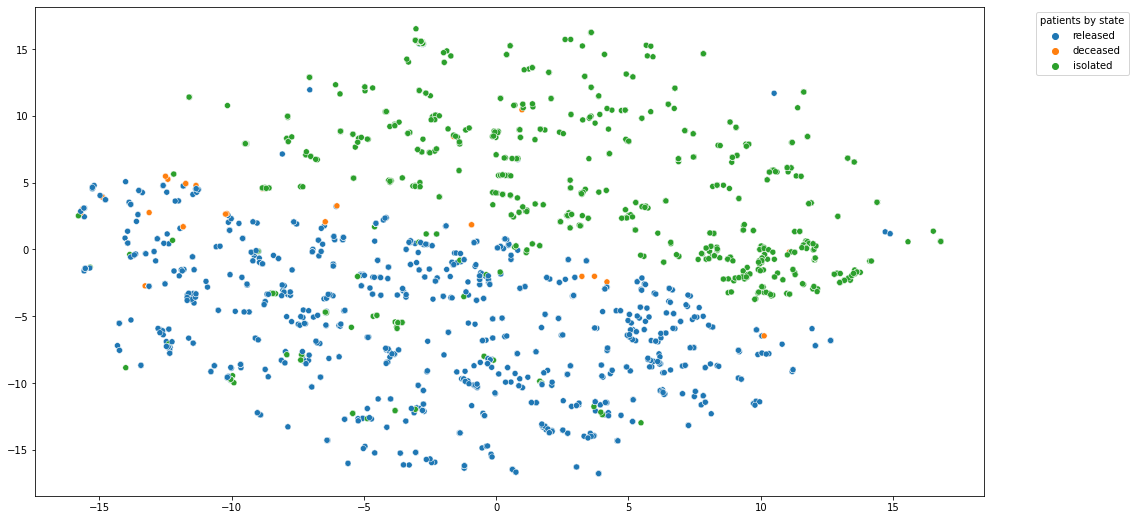

In [8]:
categorical_columns = patient_region_data.select_dtypes(include='object').columns.tolist()
patient_info_data_encode = pd.get_dummies(patient_region_data[categorical_columns], drop_first=True)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
patient_info_data_tsne = tsne.fit_transform(patient_info_data_encode)

plt.figure(figsize=(17,9))
sns.scatterplot(x=patient_info_data_tsne[:, 0], y=patient_info_data_tsne[:, 1], hue=patient_info_data.state)
plt.legend(title='patients by state', bbox_to_anchor=(1.05, 1), loc='upper left')

- It seems that we will be able to successfully make a classification between isolated and released, but we can't spot any pattern with deceased patients in 2d. We can consider making a binary classification using only Isolated and Released patients.

In [16]:
# removing deceased patients
patient_region_data = patient_region_data.drop(patient_region_data[patient_region_data['state'] == 'deceased'].index)

We will target encode some features to avoid having many dimensions

In [17]:
y_encoder = LabelEncoder()
features_to_label_encode = ['infection_case', 'province']
features_to_use = patient_region_data.drop(['state'], axis=1).columns
y = y_encoder.fit_transform(patient_region_data['state'])

patient_region_data['age'] = patient_region_data['age'].str.replace(r'\D', '').astype(int)
patient_region_data['sex'] = pd.get_dummies(patient_region_data['sex'], drop_first=True)

for column in features_to_label_encode:
  patient_region_data[column] = LabelEncoder().fit_transform(patient_region_data[column])

In [18]:
RANDOM_STATE = 7

x_train, x_test, y_train, y_test = train_test_split(
    patient_region_data[features_to_use],
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [19]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

In [20]:
param_grid = { 
    'n_estimators': [100, 1000, 5000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth' : [5, 9, 15, 25]
}

rfc_rs = RandomizedSearchCV(rfc,
                         param_grid,
                         n_iter=15,
                         cv=7,
                         n_jobs=-1,
                         random_state=RANDOM_STATE,
                         scoring='f1_micro')

rfc_rs.fit(x_train, y_train)
rfc_rs.best_params_

{'max_depth': 25, 'max_features': 'log2', 'n_estimators': 5000}

In [21]:
rfc_final = RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=5000)
rfc_final.fit(x_train, y_train)
y_predict = rfc_final.predict(x_test)

In [22]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       402
           1       0.86      0.91      0.88       438

    accuracy                           0.88       840
   macro avg       0.88      0.87      0.88       840
weighted avg       0.88      0.88      0.88       840



In [23]:
print(y_encoder.classes_)

['isolated' 'released']


In [24]:
confusion_matrix(y_test, y_predict)

array([[336,  66],
       [ 38, 400]])

- A good business decision here would be to increase the recall and have medical stuff manually examine the patients that the model had hard time evaluating.


Summary

- We've discovered that Asian countries outperformed Western countries in containing the virus spread
- We found evidence of discipline in South Korean Population
- We build a model to successfully predict between releasing and isolating patients

